In [17]:
from __future__ import print_function

import argparse
import os
import shutil
import time
import copy

import sys
sys.path.append("/ws/external")

# from models.cifar.allconv import AllConvNet
import numpy as np
from third_party.ResNeXt_DenseNet.models.densenet import densenet
from third_party.ResNeXt_DenseNet.models.resnext import resnext29
from third_party.WideResNet_pytorch.wideresnet import WideResNet
from third_party.WideResNet_pytorch.wideresnetproj import WideResNetProj
from third_party.WideResNet_pytorch.wideresnet_encoder import WideResNetEncoder
from third_party.supervised_contrastive_net import SupConNet
from models import MyDataParallel

import torch
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from datasets import *
from datasets.mixdataset import BaseDataset, AugMixDataset
from torch.utils.data import Dataset

from feature_hook import FeatureHook
from utils import WandbLogger
# from apis import test, test_c, test_c_dg, Trainer

from collections import defaultdict
import pandas as pd

### Set argument

In [18]:
class Args():
    def __init__(self):
        self.dataset = 'cifar10'
        self.num_classes=10
        
        self.aug = 'augmix'
        self.model = 'wrn'
        self.epochs = 5
        self.batch_size = 8
        self.eval_batch_size = 10
        
        self.no_jsd = False
        self.additional_loss = 'jsd'
        self.temper = 1.0
        self.lambda_weight = 12.0
                
        # '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar' # None '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar'
        self.resume = "/ws/data/log/cifar10/pixmix/pixmix_b512_jsdv3/model_best.pth.tar" # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar' # None # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar'
        self.evaluate = False
        self.analysis = True
        self.confusion_matrix = False
        self.save = '/ws/data/log/cifar10/augmix_b512' # None
        self.base_path = "/ws/data/cifar/CIFAR-10-C/"
        
        self.learning_rate = 0.001
        self.momentum = 0.9
        self.decay = 0.0005
        self.layers = 40
        self.widen_factor = 2
        self.droprate = 0.0
        self.mixture_width = 3
        self.mixture_depth = -1
        self.aug_severity = 3
        self.mixture_coefficient = 1.0
        
        self.reduction = 'batchmean'
        self.all_ops = 'all'
        self.num_workers = 4
        self.wandb_logger = None
        self.wandb = False
        
def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                               np.cos(step / total_steps * np.pi))

CORRUPTIONS = [
  'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
  'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
  'brightness', 'contrast', 'elastic_transform', 'pixelate',
  'jpeg_compression'
]

In [19]:
args = Args()

In [20]:
''' Load datasets '''
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4)])
preprocess = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5] * 3, [0.5] * 3)])
test_transform = preprocess

train_dataset = datasets.CIFAR10(
            '/ws/data/cifar', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(
    '/ws/data/cifar', train=False, transform=test_transform, download=True)
base_c_path = '/ws/data/cifar/CIFAR-10-C/'

train_dataset = AugMixDataset(train_dataset, preprocess, args.no_jsd,
                           args.all_ops, args.mixture_width, args.mixture_depth, args.aug_severity, args.mixture_coefficient)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
class ConcatDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets[0]

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [22]:
net = WideResNet(args.layers, args.num_classes, args.widen_factor, args.droprate)
net = MyDataParallel(net).cuda()
cudnn.benchmark = True
optimizer = torch.optim.SGD(
    net.parameters(),
    args.learning_rate,
    momentum=args.momentum,
    weight_decay=args.decay,
    nesterov=True)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, \
                                              lr_lambda=lambda step: get_lr(step, args.epochs * len(train_loader), 1,  1e-6 / args.learning_rate))  

if args.resume:
    if os.path.isfile(args.resume):
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('Model restored from epoch:', start_epoch)

Model restored from epoch: 95


In [23]:
def analysisv1_0(logits_clean, logits_aug1, logits_aug2=None, lambda_weight=12):

    B, C = logits_clean.size()

    p_clean, p_aug1, = F.softmax(logits_clean, dim=1),\
                       F.softmax(logits_aug1, dim=1)

    # Clamp mixture distribution to avoid exploding KL divergence
    # jsd: batchmean reduction
    p_mixture = torch.clamp((p_clean + p_aug1) / 2., 1e-7, 1).log()
    jsd = (F.kl_div(p_mixture, p_clean, reduction='batchmean') + F.kl_div(p_mixture, p_aug1, reduction='batchmean')) / 2.
    jsd_mean = (F.kl_div(p_mixture, p_clean, reduction='mean') + F.kl_div(p_mixture, p_aug1, reduction='mean')) / 2.

    # mse: mean reduction
    mse = (F.mse_loss(logits_clean, logits_aug1, reduction='mean')) / B

    # cosine_similarity: mean reduction
    similarity = F.cosine_similarity(logits_clean, logits_aug1)
    similarity = similarity.mean()

    features = {'jsd_batchmean': jsd,
                'jsd_mean': jsd_mean,
                'mse': mse,
                'similarity': similarity,
                'p_clean': p_clean,
                'p_aug1': p_aug1,
                'p_mixture': p_mixture,
                }
    loss = jsd

    return loss, features

In [24]:
base_path = args.base_path

test_c_features, test_c_mean_features = dict(), defaultdict(float)
wandb_table = pd.DataFrame(columns=CORRUPTIONS, index=['loss', 'error'])
confusion_matrices = []
import copy
original_test_dataset = copy.deepcopy(test_dataset)
original_test_dataset.data = np.load(base_path + 'clean' + '.npy')
original_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

#corruption_accs = []
#        for corruption in CORRUPTIONS:

corruption = 'gaussian_noise'
# Reference to original data is mutated
test_dataset.data = np.load(base_path + corruption + '.npy')
test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))
concat_dataset = ConcatDataset((original_test_dataset, test_dataset))
test_loader = torch.utils.data.DataLoader(
    concat_dataset,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

In [25]:
# # hook
# from feature_hook import FeatureHook

# hook = FeatureHook(["block1.layer.5.conv2",
#                     "block2.layer.5.conv2",
#                     "block3.layer.5.conv2"])
# hook.hook_multi_layer(net)

In [26]:
net.eval()
total_loss, total_correct = 0., 0.
wandb_features = dict()
confusion_matrix = torch.zeros(10, 10)
tsne_features = []
device = 'cuda'

In [27]:
# clean_data, corrupted_data = next(iter(test_loader))
# clean_data2, corrupted_data2 = next(iter(test_loader))
# corrupted_images, targets = corrupted_data
# corrupted_images2, targets = corrupted_data2
# torch.eq(corrupted_images, corrupted_images2)

In [28]:
with torch.no_grad():
#     clean_data, corrupted_data = next(iter(test_loader))
#     clean_data, corrupted_data = next(iter(test_loader))
#     clean_data, corrupted_data = next(iter(test_loader))
#     clean_data, corrupted_data = next(iter(test_loader))
    for i, (clean_data, corrupted_data) in enumerate(test_loader):
        if i == 50000 / args.eval_batch_size -2: 
            print('i: ', i)
            clean_images, _ = clean_data
            corrupted_images, targets = corrupted_data
            images_all = torch.cat([clean_images, corrupted_images], 0).to(device)
            # targets_all = torch.cat([targets, targets], 0).to(self.device)
            targets = targets.to(device)

            logits_all = net(images_all)
            logits, logits_corrupted = torch.chunk(logits_all, 2)
            additional_loss, feature = analysisv1_0(logits, logits_corrupted, None, lambda_weight=12)

            loss = F.cross_entropy(logits, targets)
            loss_corrupted = F.cross_entropy(logits_corrupted, targets)
            pred = logits.data.max(1)[1]
            pred_corrupted = logits_corrupted.data.max(1)[1]
            correct = pred.eq(targets.data).sum().item()
            correct_corrupted = pred_corrupted.eq(targets.data).sum().item()



#     total_loss += float(loss.data)
#     total_correct += pred.eq(targets.data).sum().item()
    

i:  4998


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2905: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


In [29]:
feature.keys()
# max value plot
# false case plot
# plot at the same time

dict_keys(['jsd_batchmean', 'jsd_mean', 'mse', 'similarity', 'p_clean', 'p_aug1', 'p_mixture'])

In [33]:
import matplotlib.pyplot as plt
def plot_images(images, batch_size=8):
    images = images.detach().cpu().numpy()
    images = images.transpose(0, 2, 3, 1)

    fig = plt.figure(figsize=(8, batch_size))
    for i in range(0, batch_size):
        fig.add_subplot(1, batch_size, i+1)
        plt.imshow(images[i])
    plt.axis('off')
    plt.show()

In [34]:
logits.max(1)[0]

tensor([3.5418, 3.2321, 2.0155, 2.7133, 3.7498, 2.7888, 3.2492, 3.3028, 3.9071,
        2.6784], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



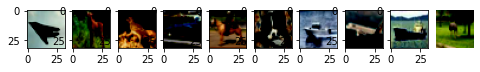

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.5418, 3.2321, 2.0155, 2.7133, 3.7498, 2.7888, 3.2492, 3.3028, 3.9071,
        2.6784], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')



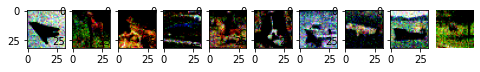

pred_corrupted: tensor([0, 4, 6, 1, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits_corrupted: tensor([3.4737, 2.7312, 2.8441, 1.2902, 3.3274, 2.7737, 3.1307, 3.2642, 3.6559,
        2.7054], device='cuda:0')
correct_corrupted: tensor([ True,  True, False, False,  True,  True,  True,  True,  True, False],
       device='cuda:0')



In [35]:
print(f"target: {targets}\n",)
print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
plot_images(clean_images, batch_size=args.eval_batch_size)
print(f"pred: {pred}\n")
print(f"logits: {logits.max(1)[0]}")
correct = pred.eq(targets.data)
print(f"correct: {correct}\n")
plot_images(corrupted_images, batch_size=args.eval_batch_size)
print(f"pred_corrupted: {pred_corrupted}\n")
print(f"logits_corrupted: {logits_corrupted.max(1)[0]}")
correct_corrupted = pred_corrupted.eq(targets.data)
print(f"correct_corrupted: {correct_corrupted}\n")


### plot scattter3d 

X_shape:  (10, 10)
Y_shape:  (10, 10)
Z_shape:  (10, 10)
correct:  tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
correct_corrupted:  tensor([ True,  True, False, False,  True,  True,  True,  True,  True, False],
       device='cuda:0')


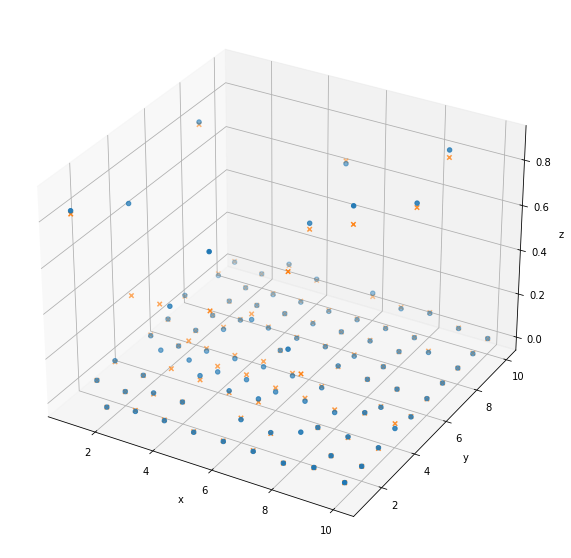

In [36]:
## plot scattter3d all value## 

x1 = np.linspace(1, 10, 10)
y1 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
z1 = feature['p_clean'].detach().cpu().numpy()
X1, Y1 = np.meshgrid(x1, y1)
Z1 = feature['p_clean'].detach().cpu().numpy()
# Z1 = feature['p_clean'][pred_correct].detach().cpu().numpy()

print('X_shape: ', np.shape(X1))
print('Y_shape: ', np.shape(Y1))
print('Z_shape: ', np.shape(Z1))
# print('z1: ', z1)

x2 = np.linspace(1, 10, 10)
y2 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
z2 = feature['p_aug1'].detach().cpu().numpy()
X2, Y2 = np.meshgrid(x2, y2)
Z2 = feature['p_aug1'].detach().cpu().numpy()
# Z2 = feature['p_aug1'][pred_correct].detach().cpu().numpy()
# print('X_shape: ', np.shape(X2))
# print('Y_shape: ', np.shape(Y2))
# print('Z_shape: ', np.shape(Z2))
# print('z2: ', z2)


fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X1, Y1, Z1, marker='o')
ax.scatter(X2, Y2, Z2, marker='x')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

print('correct: ', correct)
print('correct_corrupted: ', correct_corrupted)

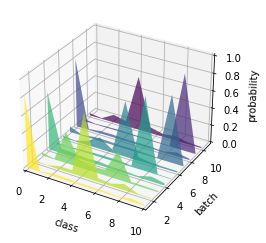

In [37]:
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import math
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]


# ax = plt.figure().add_subplot(1, 2, 1, projection='3d')

ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(0., 10., 10)
Z1 = feature['p_clean'].detach().cpu().numpy()
# B, C = np.shape(Z1)
# print(f'B: {B}, C: {C}')
k = polygon_under_graph(x, Z1[0])
# print("k: ", np.shape(k))
verts = [polygon_under_graph(x, l) for l in Z1]
# print("verts: ", np.shape(verts))

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=range(1, 11), zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 11), zlim=(0, 1.0),
       xlabel='class', ylabel='batch', zlabel='probability');


# ax = fig.add_subplot(1, 2, 2, projection='3d')

# Z2 = feature['p_aug1'].detach().cpu().numpy()
# verts2 = [polygon_under_graph(x, l) for l in Z2]
# poly2 = PolyCollection(verts2, facecolors=facecolors, alpha=.7)
# ax.add_collection3d(poly2, zs=range(1, 11), zdir='y')
# # plt.show()


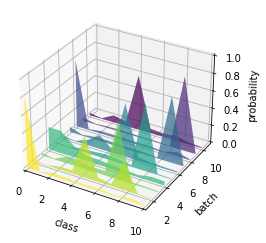

In [38]:
ax = plt.figure().add_subplot(projection='3d')

Z2 = feature['p_aug1'].detach().cpu().numpy()
x = np.linspace(0., 10., 10)
verts = [polygon_under_graph(x, l) for l in Z2]

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=range(1, 11), zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 11), zlim=(0, 1.0),
       xlabel='class', ylabel='batch', zlabel='probability');

plt.show()

In [352]:
net

MyDataParallel(
  (module): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1): NetworkBlock(
      (layer): Sequential(
        (0): BasicBlock(
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (conv_shortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BasicBlock(
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

In [357]:
net.module.features.size()

torch.Size([20, 128])

In [350]:
feature['p_clean'].detach().cpu().numpy()

array([[9.99461472e-01, 7.70978204e-06, 2.05276519e-04, 2.39659894e-05,
        6.31068451e-06, 6.08434084e-06, 5.51206722e-06, 4.45141177e-06,
        2.58014712e-04, 2.12019531e-05],
       [7.35501599e-05, 5.11064209e-05, 9.82188270e-04, 1.24106870e-03,
        9.92635310e-01, 2.84067192e-03, 3.67960631e-04, 1.69213640e-03,
        4.54669134e-05, 7.05226921e-05],
       [1.12468239e-04, 1.53720503e-05, 9.91996944e-01, 8.96273938e-04,
        1.56992942e-03, 4.92434774e-04, 4.78797080e-03, 4.91237079e-05,
        2.81036791e-05, 5.14788444e-05],
       [9.99592841e-01, 1.36661489e-04, 7.45099678e-05, 1.49695225e-05,
        2.50599824e-05, 7.23947824e-06, 1.32331279e-05, 1.54164081e-05,
        7.16289505e-05, 4.85576238e-05],
       [2.70416840e-05, 8.44673923e-06, 3.61554848e-05, 2.83281206e-05,
        5.72041281e-05, 1.30549146e-04, 1.36733925e-05, 9.99677896e-01,
        6.50213360e-06, 1.41703613e-05],
       [1.81547566e-05, 1.29920654e-05, 1.22302887e-03, 1.51357934e-01,
   

In [351]:
feature['p_aug1'].detach().cpu().numpy()

array([[9.98632610e-01, 7.09290543e-06, 8.62413784e-04, 3.85521889e-05,
        1.28246702e-05, 6.61958575e-06, 3.72424365e-05, 3.91203093e-06,
        3.85320658e-04, 1.33789717e-05],
       [4.03973754e-05, 1.28679285e-05, 7.22742290e-04, 4.89283819e-04,
        9.97282147e-01, 5.26525255e-04, 1.72983855e-04, 7.13930815e-04,
        1.76232479e-05, 2.15102009e-05],
       [1.72816450e-04, 1.13890919e-05, 5.13572171e-02, 1.37367623e-03,
        8.13519233e-04, 1.68853425e-04, 9.46013808e-01, 1.61700227e-05,
        5.18178967e-05, 2.06936129e-05],
       [2.92524248e-01, 4.43556608e-04, 7.03126907e-01, 5.72587480e-04,
        1.79124216e-03, 1.51391956e-04, 7.01089040e-04, 7.91038474e-05,
        3.14718927e-04, 2.95105157e-04],
       [1.01191079e-04, 3.00386328e-05, 6.12838659e-03, 5.56895277e-04,
        4.15951982e-02, 5.51153091e-04, 1.91148254e-04, 9.50765550e-01,
        3.66216918e-05, 4.38481984e-05],
       [2.36957185e-05, 1.02285185e-05, 1.37974322e-01, 2.75971573e-02,
   

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

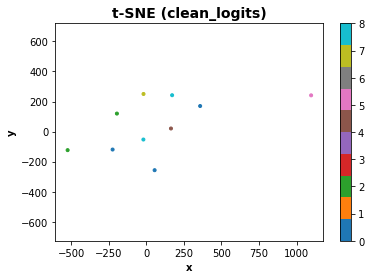

In [346]:
from utils.visualize import single_plot_tsne
single_plot_tsne(feature['p_clean'], targets, title='clean_logits')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

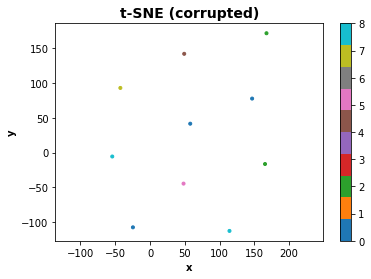

In [348]:
single_plot_tsne(feature['p_aug1'], targets, title='corrupted')

X_shape:  (10, 10)
Y_shape:  (10, 10)
Z_shape:  (10, 10)
correct:  9
correct_corrupted:  6


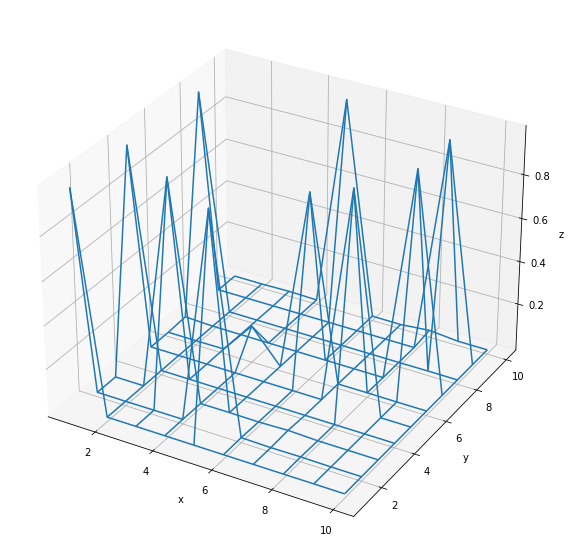

In [272]:
## plot scattter3d all value## 
size = 10
x1 = np.linspace(1, 10, 10)
y1 = np.linspace(1, size, size)
z1 = feature['p_clean'].detach().cpu().numpy()[:size, :]
X1, Y1 = np.meshgrid(x1, y1)
Z1 = feature['p_clean'].detach().cpu().numpy()[:size, :]
print('X_shape: ', np.shape(X1))
print('Y_shape: ', np.shape(Y1))
print('Z_shape: ', np.shape(Z1))
# print('z1: ', z1)

x2 = np.linspace(1, 10, 10)
y2 = np.linspace(1, size, size)
z2 = feature['p_aug1'].detach().cpu().numpy()[:size, :]
X2, Y2 = np.meshgrid(x2, y2)
Z2 = feature['p_aug1'].detach().cpu().numpy()[:size, :]
# print('X_shape: ', np.shape(X2))
# print('Y_shape: ', np.shape(Y2))
# print('Z_shape: ', np.shape(Z2))
# print('z2: ', z2)


fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.plot_surface(X1, Y1, Z1, cmap='viridis',linewidth=0)
ax.plot_wireframe(X1, Y1, Z1)
# ax.plot_surface(X2, Y2, Z2, cmap='viridis',linewidth=0)
# ax.scatter(X1, Y1, Z1, marker='o', alpha=0.5)
# ax.scatter(X2, Y2, Z2, marker='x', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

print('correct: ', correct)
print('correct_corrupted: ', correct_corrupted)

correct:  9
correct_corrupted:  6


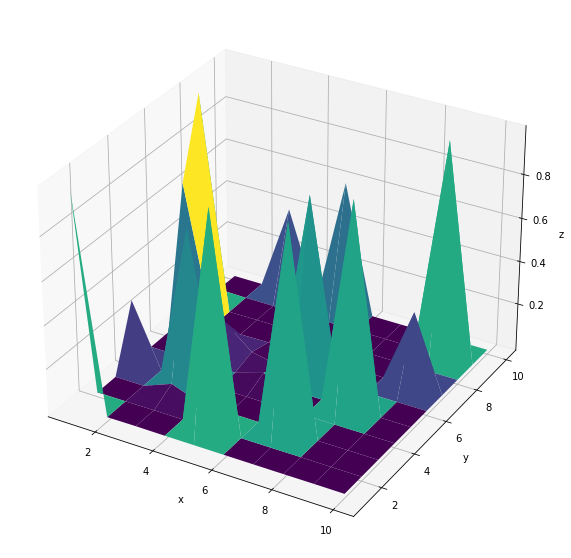

In [270]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X2, Y2, Z2, cmap='viridis',linewidth=0)
# ax.scatter(X1, Y1, Z1, marker='o', alpha=0.5)
# ax.scatter(X2, Y2, Z2, marker='x', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

print('correct: ', correct)
print('correct_corrupted: ', correct_corrupted)

correct:  9
correct_corrupted:  6


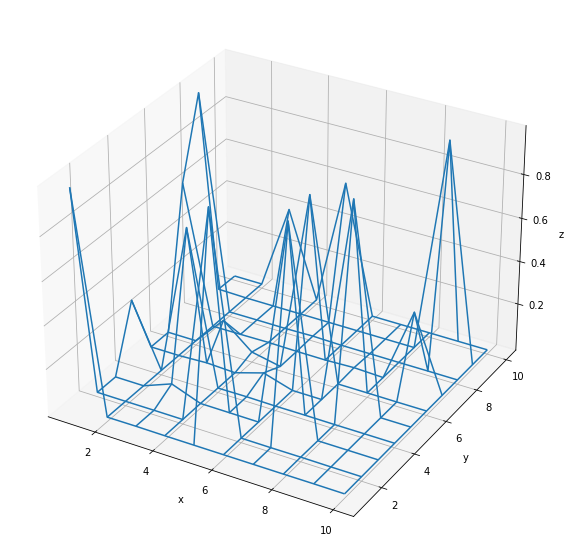

In [271]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X2, Y2, Z2)
# ax.scatter(X1, Y1, Z1, marker='o', alpha=0.5)
# ax.scatter(X2, Y2, Z2, marker='x', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

print('correct: ', correct)
print('correct_corrupted: ', correct_corrupted)

In [236]:
pred[pred_correct].size()

torch.Size([9])

In [209]:
correct

946

In [ ]:

# x1 = np.linspace(1, 10, 10)
# y1 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
# z1 = feature['p_clean'].detach().cpu().numpy()

# X1, Y1 = np.meshgrid(x, y)
# Z1 = feature['p_clean'].detach().cpu().numpy()
# print('X_shape: ', np.shape(X1))
# print('Y_shape: ', np.shape(Y1))
# print('Z_shape: ', np.shape(Z1))

# x2 = np.linspace(1, 10, 10)
# y2 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
# z2 = feature['p_aug1'].detach().cpu().numpy()

# X2, Y2 = np.meshgrid(x2, y2)
# Z2 = feature['p_aug1'].detach().cpu().numpy()
# print('X_shape: ', np.shape(X2))
# print('Y_shape: ', np.shape(Y2))
# print('Z_shape: ', np.shape(Z2))



# fig = plt.figure(figsize=(10, 10))
# ax = plt.axes(projection='3d')
# ax.scatter(X1, Y1, Z1, marker='o')
# ax.scatter(X2, Y2, Z2, marker='x')


# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z');

# print('correct: ', correct)
# print('correct_corrupted: ', correct_corrupted)

In [194]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 1000

AttributeError: 'function' object has no attribute 'ndim'

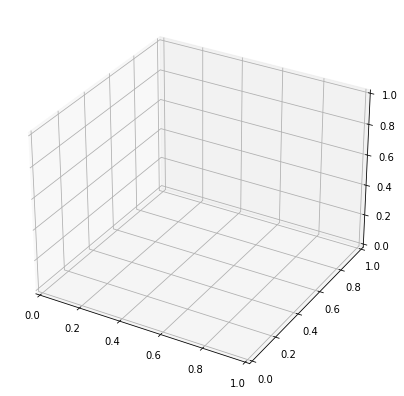

In [195]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

In [70]:
logits_all.size()

torch.Size([2000, 10])

In [73]:
logits.size()

torch.Size([1000, 10])

In [74]:
logits_corrupted.size()

torch.Size([1000, 10])

In [60]:
corrupted_images.size()

torch.Size([1000, 3, 32, 32])

In [61]:
targets.size()

torch.Size([1000])

In [ ]:
images_all = torch.cat([clean_images, corrupted_images], 0).to(self.device)
# targets_all = torch.cat([targets, targets], 0).to(self.device)
targets = targets.to(self.device)

logits_all = self.net(images_all)
logits, logits_corrupted = torch.chunk(logits_all, 2)

In [ ]:
with torch.no_grad():
    for i, (clean_data, corrupted_data) in enumerate(test_loader):
        clean_images, _ = clean_data
        corrupted_images, targets = corrupted_data

        images_all = torch.cat([clean_images, corrupted_images], 0).to(self.device)
        # targets_all = torch.cat([targets, targets], 0).to(self.device)
        targets = targets.to(self.device)

        logits_all = self.net(images_all)
        logits, logits_corrupted = torch.chunk(logits_all, 2)

#         additional_loss, feature = get_additional_loss(self.args,
#                                                        logits, logits_corrupted, None,
#                                                        self.args.lambda_weight, targets, self.args.temper,
#                                                        self.args.reduction)

In [141]:
net.train()
wandb_features = {}
total_ce_loss = 0.
total_additional_loss = 0.
total_correct = 0.
loss_ema = 0.

In [145]:
for i, (images, targets) in enumerate(test_loader): 
    optimizer.zero_grad()
    images_all = torch.cat(images, 0).cuda()
    targets = targets.cuda()

    logits_all = net(images_all)

    logits_clean, logits_aug1, logits_aug2 = torch.split(logits_all, images[0].size(0))

    pred_clean = logits_clean.data.max(1)[1]
    pred_aug1 = logits_aug1.data.max(1)[1]
    correct = pred_clean.eq(targets.data).sum().item()
    
    ce_loss = F.cross_entropy(logits_clean, targets)
    additional_loss, feature = jsdv3_01(logits_clean, logits_aug1, logits_aug2, \
                                        lambda_weight=12, temper=1.0, targets=targets, margin=1.0) 
    loss = ce_loss # + additional_loss
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    print('target: ', targets)
    print('pred_clean: ', pred_clean)
    print('pred_aug1: ', pred_aug1)
    print('ce_loss: ', ce_loss)
    print('additional_loss: ', additional_loss)
    print('jsd_distance: ', feature['jsd_distance'])
    print('jsd_distance_same_class: ', feature['jsd_distance_same_class'])
    print('jsd_distance_diff_class: ', feature['jsd_distance_diff_class'])
    print('jsd_matrix: ', feature['jsd_matrix'])
    
    if i == 0:
        break

target:  tensor([0, 5, 7, 6, 1, 7, 9, 3], device='cuda:0')
pred_clean:  tensor([0, 5, 7, 6, 1, 7, 9, 3], device='cuda:0')
pred_aug1:  tensor([0, 5, 7, 6, 1, 7, 9, 3], device='cuda:0')
ce_loss:  tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward0>)
additional_loss:  tensor(2.2465, device='cuda:0', grad_fn=<AddBackward0>)
jsd_distance:  tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)
jsd_distance_same_class:  tensor(0.0628, device='cuda:0', grad_fn=<DivBackward0>)
jsd_distance_diff_class:  tensor(0.8365, device='cuda:0', grad_fn=<DivBackward0>)
jsd_matrix:  tensor([[7.5532e-07, 9.4859e-01, 8.2249e-01, 9.2560e-01, 9.2847e-01, 7.4841e-01,
         8.7874e-01, 7.5038e-01],
        [1.0723e+00, 3.3450e-08, 6.9690e-01, 8.7009e-01, 9.2790e-01, 3.6742e-01,
         9.1479e-01, 8.4680e-01],
        [1.0352e+00, 8.5970e-01, 2.8836e-04, 9.6498e-01, 1.0084e+00, 6.2775e-02,
         9.2821e-01, 9.0831e-01],
        [1.0049e+00, 7.7166e-01, 7.7592e-01, 6.2495e-02, 8.8501e-01, 6.3319e-01

In [146]:
def plot_matrix(feature, name ):
    matrix = feature[name].cpu().detach().numpy()
    plt.figure(figsize=(batch_size, batch_size))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name)
    fmt = '.4f'
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, format(matrix[i, j], fmt),horizontalalignment="center")
    plt.xlabel('logit_contrast')
    plt.ylabel('logit_anchor')
    plt.colorbar()
def kl_div_elem(p, q, anchor, contrast, targets):
    kl_div = F.kl_div(p[anchor].log(), q[contrast], reduction='batchmean')
    print('prediction anchor: ', p[anchor])
    print('prediction contrast: ', p[contrast])
    print('targets: ', targets)
    print('kl_div:', kl_div)

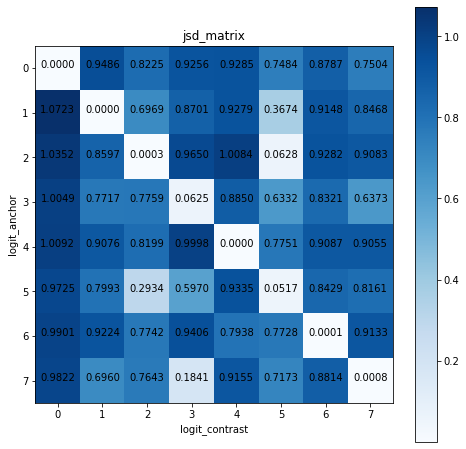

In [147]:
plot_matrix(feature, name='jsd_matrix')

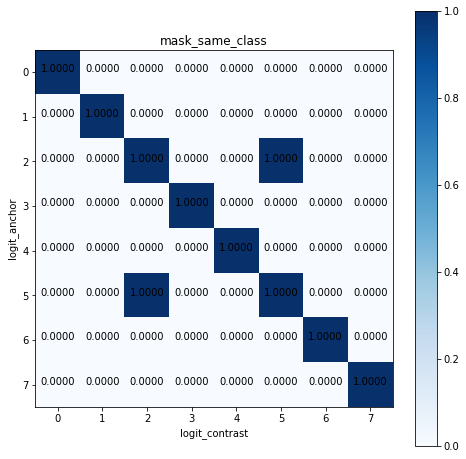

In [148]:
plot_matrix(feature, name='mask_same_class')

In [123]:
kl_div_elem(p_clean, p_aug1, 7, 7, targets)

prediction anchor:  tensor([3.6953e-05, 8.5935e-05, 9.8623e-05, 8.6294e-03, 1.0173e-04, 1.5927e-04,
        9.9065e-01, 5.7949e-05, 7.6778e-05, 1.0396e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
prediction contrast:  tensor([3.6953e-05, 8.5935e-05, 9.8623e-05, 8.6294e-03, 1.0173e-04, 1.5927e-04,
        9.9065e-01, 5.7949e-05, 7.6778e-05, 1.0396e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
targets:  tensor([4, 5, 9, 5, 7, 7, 0, 9], device='cuda:0')
kl_div: tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)


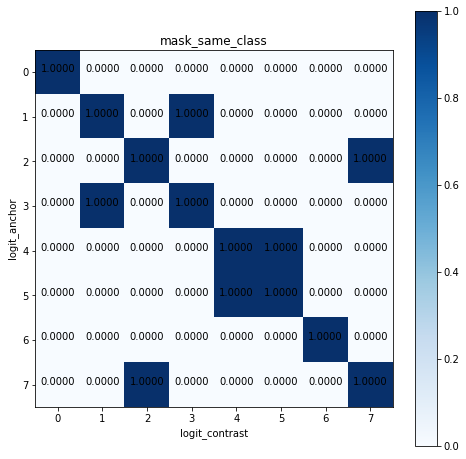

In [118]:
plot_matrix(feature, name='mask_same_class')

In [96]:
p_clean = feature['p_clean']
p_aug1 = feature['p_aug1']
p_aug2 = feature['p_aug2']
m = (p_clean + p_aug1 + p_aug2) / 3

In [ ]:
anchor = 2
contrast = 4
jsd = args.lambda_weight * (F.kl_div(p_clean[anchor].log(), m[contrast]) + F.kl_div(p_aug1[anchor].log(), m[contrast]) + F.kl_div(p_aug2[anchor].log(), m[contrast])) / 3
jsd

In [100]:
get_kl_matrix(p_clean, p_aug1)

tensor([[9.8013e-04, 9.1293e+00, 1.0464e+01, 9.2107e+00, 1.5638e+00, 9.6367e+00,
         1.0005e+01, 8.2832e+00],
        [1.0186e+01, 3.0044e-04, 9.4062e+00, 1.0065e+01, 1.1665e+00, 9.7556e+00,
         1.0384e+01, 9.0701e+00],
        [1.0664e+01, 8.6923e+00, 6.0762e-03, 8.7215e+00, 2.2190e+00, 9.6744e+00,
         9.4726e+00, 9.1549e+00],
        [9.0603e+00, 9.1226e+00, 9.9185e+00, 3.5392e-04, 4.8291e+00, 9.7390e+00,
         1.0568e+01, 9.5901e+00],
        [1.1074e+01, 6.3493e+00, 2.6273e+00, 1.0547e+01, 4.5956e+00, 1.0084e+01,
         9.7901e+00, 9.9537e+00],
        [1.0464e+01, 8.8296e+00, 9.9359e+00, 9.0520e+00, 4.8867e+00, 1.4892e-04,
         1.0091e+01, 8.9712e+00],
        [1.0353e+01, 9.6507e+00, 9.3955e+00, 1.0794e+01, 5.2215e+00, 1.0658e+01,
         7.1576e-05, 9.0803e+00],
        [1.0535e+01, 9.0857e+00, 9.3706e+00, 1.0544e+01, 4.5600e+00, 9.6818e+00,
         1.0304e+01, 1.2296e-03]], device='cuda:0', grad_fn=<SubBackward0>)

In [103]:
F.kl_div(p_clean[anchor].log(), p_aug1[contrast], reduction='batchmean')

tensor(0.5069, device='cuda:0', grad_fn=<DivBackward0>)

In [102]:
p_clean[anchor]

tensor([4.9660e-02, 2.1879e-04, 9.7908e-04, 1.9341e-04, 1.8095e-04, 1.0812e-04,
        2.2962e-04, 1.7261e-04, 9.4637e-01, 1.8927e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

prediction anchor:  tensor([4.9660e-02, 2.1879e-04, 9.7908e-04, 1.9341e-04, 1.8095e-04, 1.0812e-04,
        2.2962e-04, 1.7261e-04, 9.4637e-01, 1.8927e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)
prediction contrast:  tensor([9.9683e-01, 1.6234e-04, 6.1535e-04, 8.0041e-04, 1.2101e-04, 1.1446e-04,
        1.5998e-04, 1.7443e-04, 5.9352e-04, 4.2856e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
targets:  tensor([5, 2, 0, 7, 0, 4, 1, 6], device='cuda:0')
kl_div:  tensor(0.5069, device='cuda:0', grad_fn=<DivBackward0>)


In [10]:
device = logits_clean.device
pred_clean = logits_clean.data.max(1)[1]
pred_aug1 = logits_aug1.data.max(1)[1]
pred_aug2 = logits_aug2.data.max(1)[1]

anchor_count = 3
contrast_count = 3
batch_size = logits_clean.size()[0]
targets = targets.contiguous().view(-1, 1) # [B, 1]
temper = 1.0

mask_identical = torch.ones([batch_size, batch_size], dtype=torch.float32).to(device)
mask_triu = torch.triu(mask_identical.clone().detach())
mask_same_instance = torch.eye(batch_size, dtype=torch.float32).to(device) # [B, B]
mask_triuu = mask_triu - mask_same_instance

mask_same_class = torch.eq(targets, targets.T).float() # [B, B]
mask_diff_class = 1 - mask_same_class # [B, B]
p_clean, p_aug1, p_aug2 = F.softmax(logits_clean / temper, dim=1),\
                              F.softmax(logits_aug1 / temper, dim=1), \
                              F.softmax(logits_aug2 / temper, dim=1)
p_mixture = (p_clean + p_aug1 + p_aug2) / 3
m = (p_clean + p_aug1 +p_aug2) / 3

In [12]:
def supconv0_01(logits_clean, logits_aug1, logits_aug2, labels=None, lambda_weight=0.1, temper=0.07, reduction='batchmean'):

    """
    original supcontrast loss
    """

    mask = None
    contrast_mode = 'all'
    base_temper = temper
    device = logits_clean.device

    # temporary deprecated
    logits_clean, logits_aug1, logits_aug2 = F.normalize(logits_clean, dim=1), \
                                             F.normalize(logits_aug1, dim=1), \
                                             F.normalize(logits_aug2, dim=1),


    logits_clean, logits_aug1, logits_aug2 = torch.unsqueeze(logits_clean, dim=1), \
                                             torch.unsqueeze(logits_aug1, dim=1), \
                                             torch.unsqueeze(logits_aug2, dim=1)
    features = torch.cat([logits_clean, logits_aug1, logits_aug2], dim=1)

    if len(features.shape) < 3:
        raise ValueError('`features` needs to be [bsz, n_views, ...],'
                         'at least 3 dimensions are required')
    if len(features.shape) > 3:
        features = features.view(features.shape[0], features.shape[1], -1)

    batch_size = features.shape[0]
    if labels is not None and mask is not None:
        raise ValueError('Cannot define both `labels` and `mask`')
    elif labels is None and mask is None:
        mask = torch.eye(batch_size, dtype=torch.float32).to(device)
    elif labels is not None:
        labels = labels.contiguous().view(-1, 1)
        if labels.shape[0] != batch_size:
            raise ValueError('Num of labels does not match num of features')
        mask = torch.eq(labels, labels.T).float().to(device)
    else:
        mask = mask.float().to(device)

    contrast_count = features.shape[1]
    contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
    if contrast_mode == 'one':
        anchor_feature = features[:, 0]
        anchor_count = 1
    elif contrast_mode == 'all':
        anchor_feature = contrast_feature
        anchor_count = contrast_count
    else:
        raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

    # compute logits
    anchor_dot_contrast = torch.div(
        torch.matmul(anchor_feature, contrast_feature.T),
        temper)
    # for numerical stability
    logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
    logits = anchor_dot_contrast - logits_max.detach()

    # tile mask
    mask = mask.repeat(anchor_count, contrast_count)
    # mask-out self-contrast cases
    logits_mask = torch.scatter(
        torch.ones_like(mask),
        1,
        torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
        0
    )
    mask = mask * logits_mask

    # compute log_prob
    exp_logits = torch.exp(logits) * logits_mask
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

    # compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

    # loss
    loss = - (temper / base_temper) * mean_log_prob_pos
    loss = loss.view(anchor_count, batch_size).mean()
    loss *= lambda_weight

    return loss


In [33]:
supconv0_01(logits_clean, logits_aug1, logits_aug2, labels=targets, lambda_weight=1, temper=0.07, reduction='batchmean')

tensor(2.8626, device='cuda:0', grad_fn=<MulBackward0>)

In [12]:
jsd_matrix = get_jsd_matrix(p_clean, p_aug1, p_aug2)
jsd_matrix_same_instance = jsd_matrix * mask_same_instance 
jsd_distance = args.lambda_weight * jsd_matrix_same_instance.sum() / mask_same_instance.sum()
jsd_matrix_same_instance

tensor([[3.2202e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.8783e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.4466e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.6264e-04, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7998e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9153e-05,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.7688e-04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.5472e-04]], device='cuda:0', grad_fn=<MulBackward0>)

In [55]:
temper = 1
logits_clean_norm, logits_aug1_norm, logits_aug2_norm = F.normalize(logits_clean, dim=1), \
                                         F.normalize(logits_aug1, dim=1), \
                                         F.normalize(logits_aug2, dim=1),


# logits_clean_norm, logits_aug1_norm, logits_aug2_norm = torch.unsqueeze(logits_clean_norm, dim=1), \
#                                          torch.unsqueeze(logits_aug1_norm, dim=1), \
#                                          torch.unsqueeze(logits_aug2_norm, dim=1)


anchor_dot_contrast = torch.div(torch.matmul(logits_clean_norm, logits_aug1_norm.T), temper)
logits_max , _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
logits = anchor_dot_contrast - logits_max.detach()

In [58]:
mask_same_instance

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [59]:
mask_diff_class

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.]], device='cuda:0')

In [60]:
mask_same_instance_diff_class = mask_same_instance + mask_diff_class

In [61]:
mask_same_instance_diff_class

tensor([[1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')

In [63]:
exp_logits = torch.exp(logits) * mask_same_instance_diff_class
exp_logits

tensor([[1.0000, 0.0000, 0.9432, 0.9586, 0.9541, 0.9227, 0.9636, 0.9379],
        [0.0000, 1.0000, 0.9494, 0.9475, 0.9606, 0.9484, 0.9443, 0.9457],
        [1.0000, 0.9274, 0.9404, 0.9532, 0.0000, 0.8952, 0.9611, 0.9464],
        [1.0000, 0.9602, 0.9410, 0.9681, 0.9751, 0.9227, 0.9695, 0.9455],
        [1.0000, 0.9512, 0.0000, 0.9596, 0.9797, 0.9237, 0.9721, 0.9713],
        [0.9263, 0.9559, 0.9678, 0.9743, 0.9662, 1.0000, 0.9631, 0.9717],
        [0.9948, 0.9598, 0.9701, 0.9888, 0.9874, 0.9558, 1.0000, 0.9725],
        [0.9832, 0.9367, 0.9585, 0.9541, 1.0000, 0.9214, 0.9781, 0.9819]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [64]:
log_prob = logits - tor`ch.log(exp_logits.sum(1, keepdim=True))
log_prob

tensor([[-1.8991, -1.9211, -1.9576, -1.9415, -1.9461, -1.9796, -1.9362, -1.9633],
        [-1.9569, -1.9015, -1.9534, -1.9554, -1.9417, -1.9545, -1.9588, -1.9573],
        [-1.8906, -1.9661, -1.9521, -1.9386, -1.9173, -2.0014, -1.9303, -1.9457],
        [-2.0389, -2.0795, -2.0997, -2.0713, -2.0641, -2.1193, -2.0699, -2.0949],
        [-1.9107, -1.9607, -1.9480, -1.9519, -1.9312, -1.9901, -1.9390, -1.9398],
        [-2.1210, -2.0896, -2.0772, -2.0706, -2.0789, -2.0445, -2.0821, -2.0732],
        [-2.0631, -2.0989, -2.0882, -2.0691, -2.0706, -2.1031, -2.0579, -2.0858],
        [-2.0600, -2.1084, -2.0854, -2.0900, -2.0430, -2.1249, -2.0652, -2.0613]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [65]:
(mask_same_instance * log_prob)

tensor([[-1.8991, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -1.9015, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -1.9521, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -2.0713, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -1.9312, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -2.0445, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -2.0579, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -2.0613]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [67]:
(mask_same_instance * log_prob).sum(1)

tensor([-1.8991, -1.9015, -1.9521, -2.0713, -1.9312, -2.0445, -2.0579, -2.0613],
       device='cuda:0', grad_fn=<SumBackward1>)

In [66]:
mask_same_instance.sum(1)

tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [68]:
mean_log_prob_pos = (mask_same_instance * log_prob).sum(1) / mask_same_instance.sum(1)
mean_log_prob_pos

tensor([-1.8991, -1.9015, -1.9521, -2.0713, -1.9312, -2.0445, -2.0579, -2.0613],
       device='cuda:0', grad_fn=<DivBackward0>)

In [73]:
base_temper = temper
loss = - (temper / base_temper) * mean_log_prob_pos
loss *= 12 * loss.mean()
loss

tensor([45.3485, 45.4050, 46.6126, 49.4588, 46.1141, 48.8194, 49.1383, 49.2199],
       device='cuda:0', grad_fn=<MulBackward0>)

In [30]:
mask_same_instance

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [31]:
mask_same_instance + mask_diff_instance

NameError: name 'mask_diff_instance' is not defined

In [25]:
anchor_dot_contrast

tensor([[0.1034, 0.1038, 0.1035, 0.1037, 0.1033, 0.1031, 0.1035, 0.1033],
        [0.1035, 0.1041, 0.1038, 0.1040, 0.1035, 0.1035, 0.1038, 0.1036],
        [0.1038, 0.1038, 0.1038, 0.1041, 0.1037, 0.1034, 0.1040, 0.1038],
        [0.1039, 0.1041, 0.1039, 0.1043, 0.1038, 0.1036, 0.1041, 0.1038],
        [0.1028, 0.1029, 0.1029, 0.1031, 0.1028, 0.1026, 0.1029, 0.1029],
        [0.1027, 0.1031, 0.1031, 0.1033, 0.1028, 0.1029, 0.1030, 0.1029],
        [0.1029, 0.1032, 0.1031, 0.1033, 0.1029, 0.1028, 0.1031, 0.1029],
        [0.1033, 0.1035, 0.1035, 0.1036, 0.1033, 0.1031, 0.1035, 0.1034]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [26]:
mask_same_class

tensor([[1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [28]:
mask_diff_class

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.]], device='cuda:0')

In [29]:
anchor_dot_contrast * mask_diff_class

tensor([[0.0000, 0.0000, 0.1035, 0.1037, 0.1033, 0.1031, 0.1035, 0.1033],
        [0.0000, 0.0000, 0.1038, 0.1040, 0.1035, 0.1035, 0.1038, 0.1036],
        [0.1038, 0.1038, 0.0000, 0.1041, 0.0000, 0.1034, 0.1040, 0.1038],
        [0.1039, 0.1041, 0.1039, 0.0000, 0.1038, 0.1036, 0.1041, 0.1038],
        [0.1028, 0.1029, 0.0000, 0.1031, 0.0000, 0.1026, 0.1029, 0.1029],
        [0.1027, 0.1031, 0.1031, 0.1033, 0.1028, 0.0000, 0.1030, 0.1029],
        [0.1029, 0.1032, 0.1031, 0.1033, 0.1029, 0.1028, 0.0000, 0.1029],
        [0.1033, 0.1035, 0.1035, 0.1036, 0.1033, 0.1031, 0.1035, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [32]:
mask_diff_triuu = mask_diff_class * mask_triuu
jsd_matrix_diff_class = jsd_matrix * mask_diff_triuu
jsd_distance_diff_class =  args.lambda_weight * jsd_matrix_diff_class.sum() / mask_diff_triuu.sum()
jsd_matrix_diff_class

tensor([[0.0000, 0.0012, 0.0022, 0.0017, 0.0013, 0.0044, 0.0020, 0.0009],
        [0.0000, 0.0000, 0.0026, 0.0000, 0.0021, 0.0038, 0.0018, 0.0028],
        [0.0000, 0.0000, 0.0000, 0.0046, 0.0028, 0.0023, 0.0026, 0.0032],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0012, 0.0069, 0.0024, 0.0016],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0038, 0.0021, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0030, 0.0063],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0029],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [33]:
mask_same_triuu = mask_same_class * mask_triuu
jsd_matrix_same_class = jsd_matrix * mask_same_triuu
jsd_distance_same_class =  args.lambda_weight * jsd_matrix_same_class.sum() / mask_same_triuu.sum()
jsd_matrix_same_class

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0034, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [34]:
jsd_matrix_same_class_max, _ = jsd_matrix_same_class.max(dim=1, keepdim=True)
# jsd_matrix_same_class_mean = jsd_matrix_same_class.sum(dim=1, keepdim=True) # to be developed
jsd_matrix_same_class_max =  jsd_matrix_same_class_max.repeat((1, batch_size)) * mask_diff_triuu
jsd_matrix_same_class_max

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0034, 0.0000, 0.0034, 0.0034, 0.0034, 0.0034],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021, 0.0021, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [35]:
(jsd_matrix_same_class_max - jsd_matrix_diff_class) * mask_diff_triuu

tensor([[ 0.0000e+00, -1.1969e-03, -2.2244e-03, -1.6932e-03, -1.2667e-03,
         -4.3880e-03, -1.9775e-03, -9.0273e-04],
        [ 0.0000e+00,  0.0000e+00,  7.1295e-04,  0.0000e+00,  1.2271e-03,
         -4.1501e-04,  1.5747e-03,  5.7562e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.6464e-03, -2.7618e-03,
         -2.3385e-03, -2.5628e-03, -3.2086e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2121e-03,
         -6.9049e-03, -2.4056e-03, -1.6282e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.7684e-03,  1.5179e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.9736e-03, -6.2524e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -2.9447e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0'

In [36]:
margin = 5.0
triplet_matrix = torch.clamp((jsd_matrix_same_class_max - jsd_matrix_diff_class + margin) * mask_diff_triuu, min=0)
triplet_matrix

tensor([[0.0000, 0.9988, 0.9978, 0.9983, 0.9987, 0.9956, 0.9980, 0.9991],
        [0.0000, 0.0000, 1.0007, 0.0000, 1.0012, 0.9996, 1.0016, 1.0006],
        [0.0000, 0.0000, 0.0000, 0.9954, 0.9972, 0.9977, 0.9974, 0.9968],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9988, 0.9931, 0.9976, 0.9984],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9982, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9970, 0.9937],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9971],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [37]:
count = (torch.count_nonzero(jsd_matrix_same_class, dim=1) + 1e-7)
count = count.unsqueeze(dim=1)
count.size()

torch.Size([8, 1])

In [38]:
jsd_matrix_same_class_mean = jsd_matrix_same_class.sum(dim=1, keepdim=True) / count
jsd_matrix_same_class_mean = jsd_matrix_same_class_mean.repeat((1, batch_size)) * mask_diff_triuu
jsd_matrix_same_class_mean

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0034, 0.0000, 0.0034, 0.0034, 0.0034, 0.0034],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021, 0.0021, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [39]:
margin = 0.04
triplet_matrix2 = torch.clamp((jsd_matrix_same_class_mean - jsd_matrix_diff_class + margin) * mask_diff_triuu, min=0)
triplet_matrix2

tensor([[0.0000, 0.0388, 0.0378, 0.0383, 0.0387, 0.0356, 0.0380, 0.0391],
        [0.0000, 0.0000, 0.0407, 0.0000, 0.0412, 0.0396, 0.0416, 0.0406],
        [0.0000, 0.0000, 0.0000, 0.0354, 0.0372, 0.0377, 0.0374, 0.0368],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0388, 0.0331, 0.0376, 0.0384],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0382, 0.0400, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0370, 0.0337],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0371],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [118]:
margin = 0.001


In [126]:
jsd_matrix_triplet.sum() / torch.count_nonzero(jsd_matrix_triplet)

tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)

In [122]:
k = torch.count_nonzero(jsd_matrix_triplet)

In [125]:
k.requires_grad

False

tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
jsd_distance_diff_class

In [79]:
jsd_distance_same_class

tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>)

In [80]:
jsd_distance

tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)

In [86]:
def jsdv3(logits_clean, logits_aug1, logits_aug2, lambda_weight=12, temper=1.0, targets=None):
    '''
    JSD loss edited: mixture probability is prediction probability from jsdv2
    '''

    device = logits_clean.device
    pred_clean = logits_clean.data.max(1)[1]
    pred_aug1 = logits_aug1.data.max(1)[1]
    pred_aug2 = logits_aug2.data.max(1)[1]

    anchor_count = 3
    contrast_count = 3
    batch_size = logits_clean.size()[0]
    targets = targets.contiguous().view(-1, 1) # [B, 1]
    temper = 1.0

    mask_identical = torch.ones([batch_size, batch_size], dtype=torch.float32).to(device)
    mask_triu = torch.triu(mask_identical.clone().detach())
    mask_same_instance = torch.eye(batch_size, dtype=torch.float32).to(device) # [B, B]
    mask_same_class = torch.eq(targets, targets.T).float() # [B, B]
    mask_diff_class = 1 - mask_same_class # [B, B]
    p_clean, p_aug1, p_aug2 = F.softmax(logits_clean / temper, dim=1),\
                                  F.softmax(logits_aug1 / temper, dim=1), \
                                  F.softmax(logits_aug2 / temper, dim=1)
    p_mixture = (p_clean + p_aug1 + p_aug2) / 3
    
    jsd_matrix = get_jsd_matrix(p_clean, p_aug1, p_aug2)
    jsd_matrix_same_instance = jsd_matrix * mask_same_instance 
    jsd_distance = jsd_matrix_same_instance.sum() / mask_same_instance.sum()
    
    mask_diff_triu = mask_diff_class * mask_triu
    jsd_matrix_diff_class = jsd_matrix * mask_diff_triu
    jsd_distance_diff_class =  jsd_matrix_diff_class.sum() / mask_diff_triu.sum()

    mask_same_triu = mask_same_class * mask_triu
    jsd_matrix_same_class = jsd_matrix * mask_same_triu
    jsd_distance_same_class =  jsd_matrix_same_class.sum() / mask_same_triu.sum()
    
    wandb_features = {'jsd_distance': jsd_distance,
                      'jsd_distance_diff_class': jsd_distance_diff_class, 
                      'jsd_distance_same_class': jsd_distance_same_class,
                     }
    
    loss = lambda_weight * jsd_distance

    return loss, wandb_features


In [87]:
jsdv3(logits_clean, logits_aug1, logits_aug2, lambda_weight=12, temper=1.0, targets=targets)

(tensor(0.0116, device='cuda:0', grad_fn=<MulBackward0>),
 {'jsd_distance': tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>),
  'jsd_distance_diff_class': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>),
  'jsd_distance_same_class': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)})

In [93]:
mask_same_instance = torch.eye(batch_size, dtype=torch.float32).to(device)
mask_same_instance.cpu().detach().numpy()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [92]:
targets_o = targets.unsqueeze(0)
targets_t = targets_o.T
mask_same_class = torch.eq(targets_o, targets_t).float() 
mask_same_class.cpu().detach().numpy()

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.]], dtype=float32)

In [94]:
mask_diff_class = 1 - mask_same_class
mask_diff_class.cpu().detach().numpy()

array([[0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]], dtype=float32)

In [152]:


pred_clean = logits_clean.data.max(1)[1]
pred_aug1 = logits_aug1.data.max(1)[1]
pred_aug2 = logits_aug2.data.max(1)[1]

# # Cross-entropy is only computed on clean images
# ce_loss = F.cross_entropy(logits_clean, targets)
# additional_loss = jsdv3(logits_clean, logits_aug1, logits_aug2, targets=targets)


In [228]:
class Trainer():
    def __init__(self, net, wandb_logger=None):
        self.wandb_logger = wandb_logger
        self.wandb_input = dict()

        self.net = net

    def train(self, train_loader, args, optimizer, scheduler, get_additional_loss):
        """Train for one epoch."""
        self.net.train()
        wandb_features = {}
        total_ce_loss = 0.
        total_additional_loss = 0.
        total_correct = 0.
        loss_ema = 0.
        for i, (images, targets) in enumerate(train_loader):
            if self.wandb_logger is not None:
                self.wandb_logger.before_train_iter()

            optimizer.zero_grad()

            if args.no_jsd or args.aug == 'none':
                # no apply additional loss. augmentations are optional
                # aug choices = ['none', 'augmix',..]
                images = images.cuda()
                targets = targets.cuda()

                logits = self.net(images)
                self.wandb_input = self.net.get_wandb_input()
                loss = F.cross_entropy(logits)
                pred = logits.data.max(1)[1]
                total_ce_loss += float(loss.data)
                total_correct += pred.eq(targets.data).sum().item()

            else:
                # apply additional loss
                images_all = torch.cat(images, 0).cuda()
                targets = targets.cuda()

                logits_all = self.net(images_all)

                self.wandb_input = self.net.get_wandb_input()
                logits_clean, logits_aug1, logits_aug2 = torch.split(logits_all, images[0].size(0))
                pred = logits_clean.data.max(1)[1]

                # Cross-entropy is only computed on clean images
                ce_loss = F.cross_entropy(logits_clean, targets)
                additional_loss = get_additional_loss(logits_clean, logits_aug1, logits_aug2)
                # additional_loss = get_additional_loss(args.additional_loss, logits_clean, logits_aug1, logits_aug2,
                #                                       args.lambda_weight, targets, args.temper, args.reduction)

                loss = ce_loss + additional_loss
                total_ce_loss += float(ce_loss.data)
                total_additional_loss += float(additional_loss.data)
                total_correct += pred.eq(targets.data).sum().item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_ema = loss_ema * 0.9 + float(loss) * 0.1


            if self.wandb_logger is not None:
                self.wandb_logger.after_train_iter(self.wandb_input)

        wandb_features['train/ce_loss'] = total_ce_loss / len(train_loader.dataset)
        wandb_features['train/additional_loss'] = total_additional_loss / len(train_loader.dataset)
        wandb_features['train/loss'] = (total_ce_loss + total_additional_loss) / len(train_loader.dataset)
        wandb_features['train/error'] = 100 - 100. * total_correct / len(train_loader.dataset)
        return loss_ema, wandb_features

In [229]:
def jsdv3(logits_clean, logits_aug1, logits_aug2, lambda_weight=12, temper=1.0, targets=None):
    '''
    JSD loss edited: mixture probability is prediction probability from jsdv2
    '''

    p_clean, p_aug1, p_aug2 = F.softmax(logits_clean / temper, dim=1),\
                              F.softmax(logits_aug1 / temper, dim=1), \
                              F.softmax(logits_aug2 / temper, dim=1)

    # Clamp mixture distribution to avoid exploding KL divergence
    p_mixture = (p_clean + p_aug1 + p_aug2) / 3
    loss = lambda_weight * (F.kl_div(p_clean.log(), p_mixture, reduction='batchmean') +
                            F.kl_div(p_aug1.log(), p_mixture, reduction='batchmean') +
                            F.kl_div(p_aug2.log(), p_mixture, reduction='batchmean')) / 3.

    return loss

In [ ]:
def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                               np.cos(step / total_steps * np.pi))

net2 = WideResNet(layers, num_classes, widen_factor, droprate)
net2 = MyDataParallel(net).cuda()
cudnn.benchmark = True
optimizer = torch.optim.SGD(
    net2.parameters(),
    args.learning_rate,
    momentum=args.momentum,
    weight_decay=args.decay,
    nesterov=True)
if args.resume:
    if os.path.isfile(args.resume):
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('Model restored from epoch:', start_epoch)


In [ ]:

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        args.epochs * len(train_loader),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / args.learning_rate))

if not os.path.exists(save):
    os.makedirs(save)
if not os.path.isdir(save):
    raise Exception('%s is not a dir' % args.save)

trainer = Trainer(net, wandb_logger=wandb_logger)
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)
for epoch in range(start_epoch, args.epochs):
    begin_time = time.time()
    train_loss_ema, train_features = trainer.train(train_loader, args, optimizer, scheduler, jsdv3)

train_features

In [262]:
from apis.cifar.test import test
import pandas as pd

CORRUPTIONS = [
    'clean', 'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

# CORRUPTIONS = [
#     'clean', 'gaussian_noise', 
# ]


def test_c(net, test_data, args, base_path):
    """
    Evaluate network on given corrupted dataset.
    return:
    corruption_acc
    wandb_table: loss and error rate for each corruption dataset.
    confusion_matrix
    tsne_features
    """
    corruption_accs = []
    wandb_features = dict()
    wandb_plts = dict()
    wandb_table = pd.DataFrame(columns=CORRUPTIONS, index=['loss', 'error'])
    confusion_matrices = []

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=args.eval_batch_size,
            shuffle=False,
            num_workers=args.num_workers,
            pin_memory=True)

        test_loss, test_acc, _, confusion_matrix = test(net, test_loader, args, data_type=corruption)

        wandb_table[corruption]['loss'] = test_loss
        wandb_table[corruption]['error'] = 100 - 100. * test_acc

        corruption_accs.append(test_acc)
        confusion_matrices.append(confusion_matrix.cpu().detach().numpy())
        print('{}\n\tTest Loss {:.3f} | Test Error {:.3f}'.format(
            corruption, test_loss, 100 - 100. * test_acc))

    return np.mean(corruption_accs), wandb_table, np.mean(confusion_matrices, axis=0)

def test(net, test_loader, args, data_type='clean'):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    wandb_features = dict()
    confusion_matrix = torch.zeros(10, 10)

    with torch.no_grad():
        ########## edited ############
        iterator = iter(test_loader)
        for i in range(len(test_loader)):
            images, targets = next(iterator)
        
        ########## edited ############
#         for images, targets in test_loader:

        images, targets = images.cuda(), targets.cuda()
        logits = net(images)

        if args.analysis:
            from utils.visualize import multi_plot_tsne
            input_list = [net.module.features, logits]
            targets_list = [targets, targets]
            title_list = ['features', 'logits']
            save_path = os.path.join(args.save, 'analysis', data_type + '.jpg')

            tsne, fig = multi_plot_tsne(input_list, targets_list, title_list, rows=1, cols=2,
                                        perplexity=30, n_iter=300,
                                        save=save_path, log_wandb=args.wandb, data_type=data_type)

        loss = F.cross_entropy(logits, targets)
        pred = logits.data.max(1)[1]
        total_loss += float(loss.data)
        total_correct += pred.eq(targets.data).sum().item()

        for t, p in zip(targets.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    wandb_features['test/loss'] = total_loss / len(test_loader.dataset)
    wandb_features['test/error'] = 100 - 100. * total_correct / len(test_loader.dataset)
    ########## edited ############ 
#     return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset), wandb_features, confusion_matrix
    return total_loss / args.eval_batch_size, total_correct / args.eval_batch_size, wandb_features, confusion_matrix
    ########## edited ############ 


clean
	Test Loss 0.000 | Test Error 5.100
gaussian_noise
	Test Loss 0.001 | Test Error 30.850
shot_noise
	Test Loss 0.001 | Test Error 25.100
impulse_noise
	Test Loss 0.001 | Test Error 30.150
defocus_blur
	Test Loss 0.000 | Test Error 8.050
glass_blur
	Test Loss 0.001 | Test Error 29.200
motion_blur
	Test Loss 0.000 | Test Error 11.750
zoom_blur
	Test Loss 0.000 | Test Error 10.000
snow
	Test Loss 0.000 | Test Error 15.150
frost
	Test Loss 0.000 | Test Error 16.700


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

fog
	Test Loss 0.000 | Test Error 19.650


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

brightness
	Test Loss 0.000 | Test Error 7.400
contrast
	Test Loss 0.000 | Test Error 20.700
elastic_transform
	Test Loss 0.000 | Test Error 18.200
pixelate
	Test Loss 0.001 | Test Error 33.900
jpeg_compression
	Test Loss 0.000 | Test Error 16.150


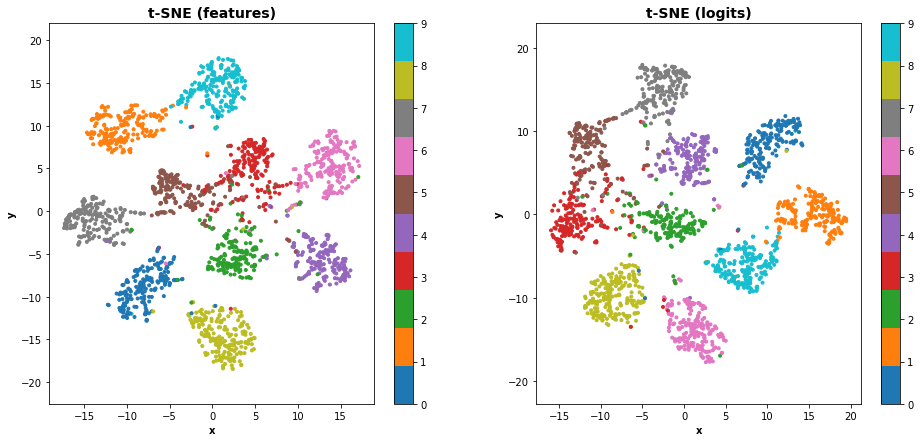

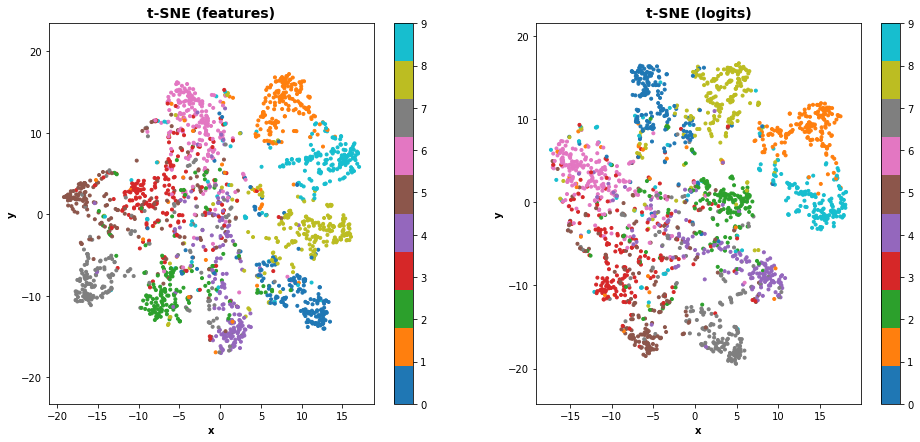

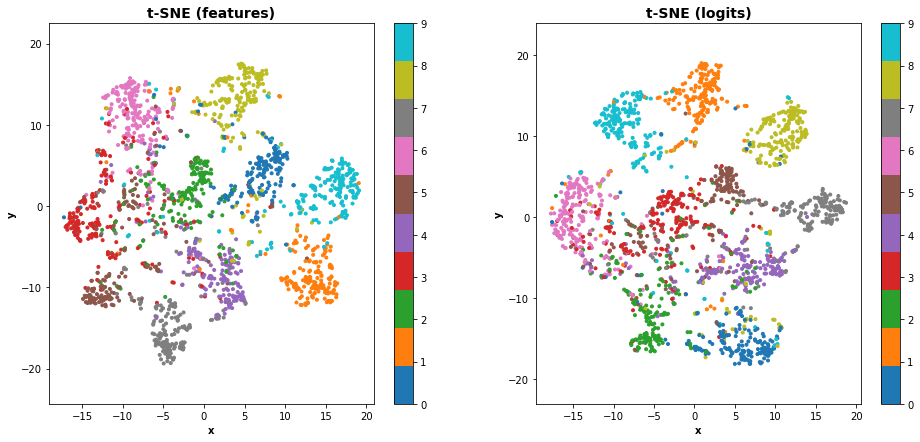

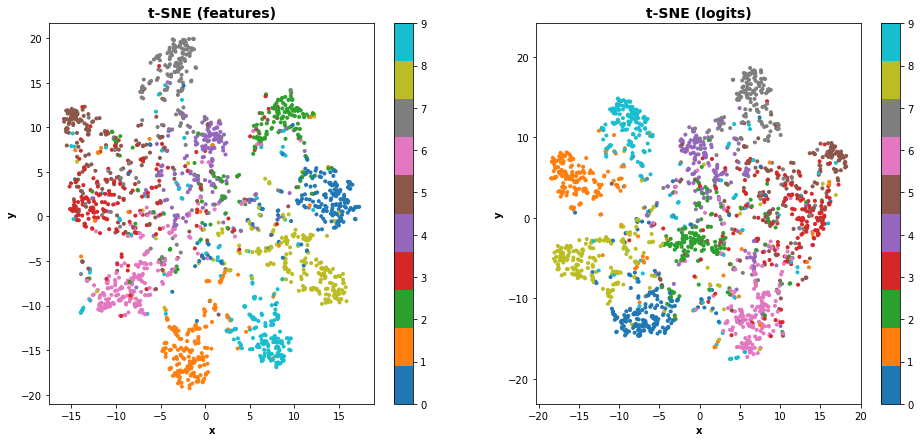

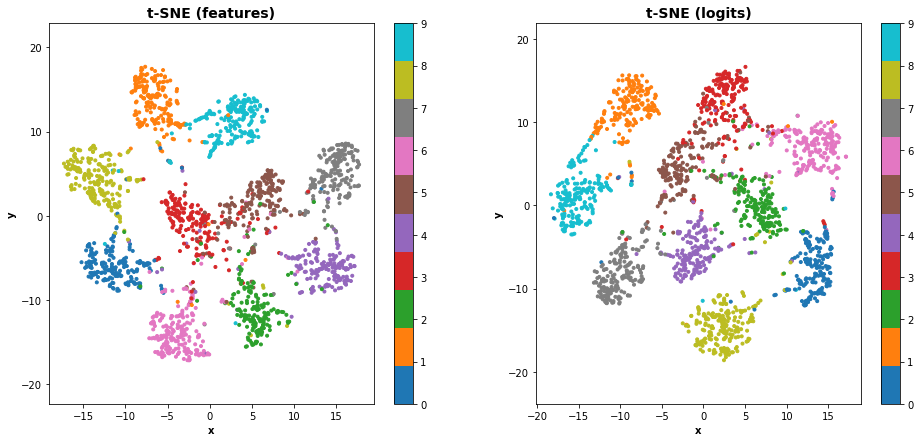

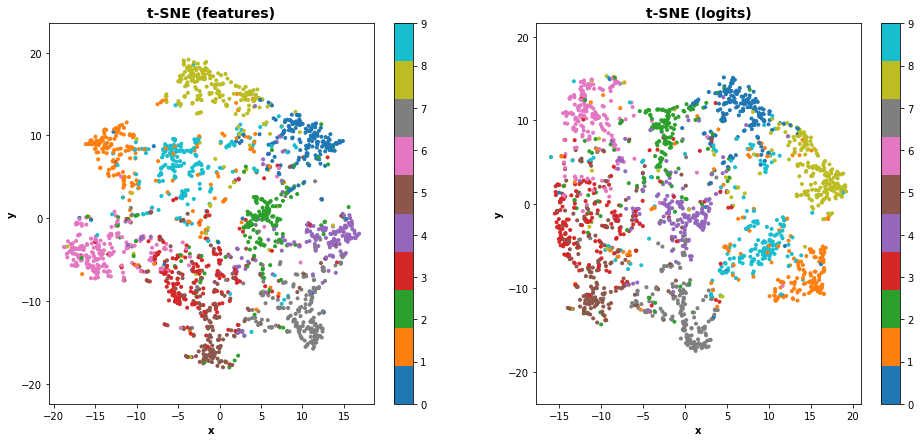

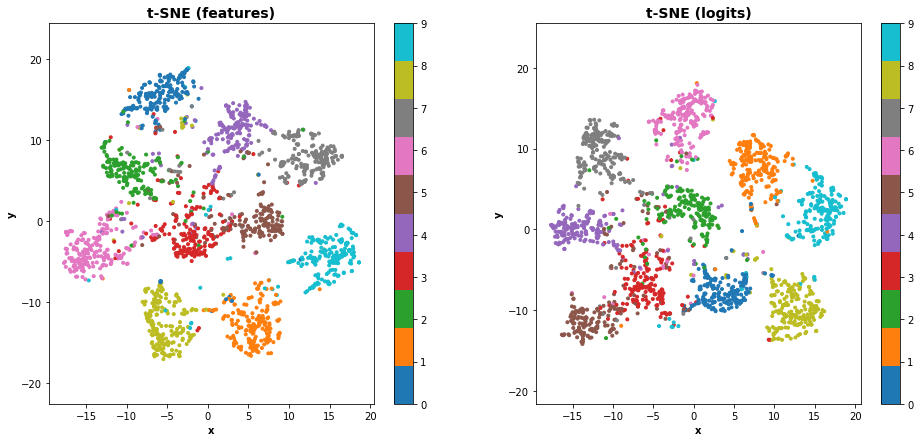

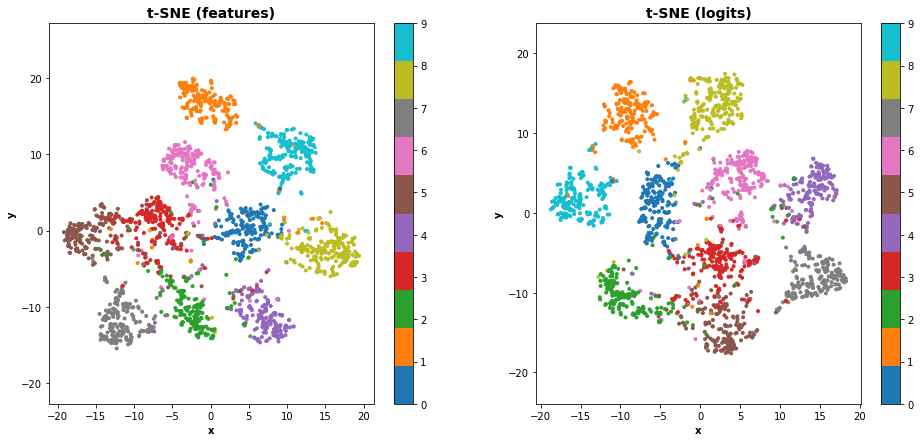

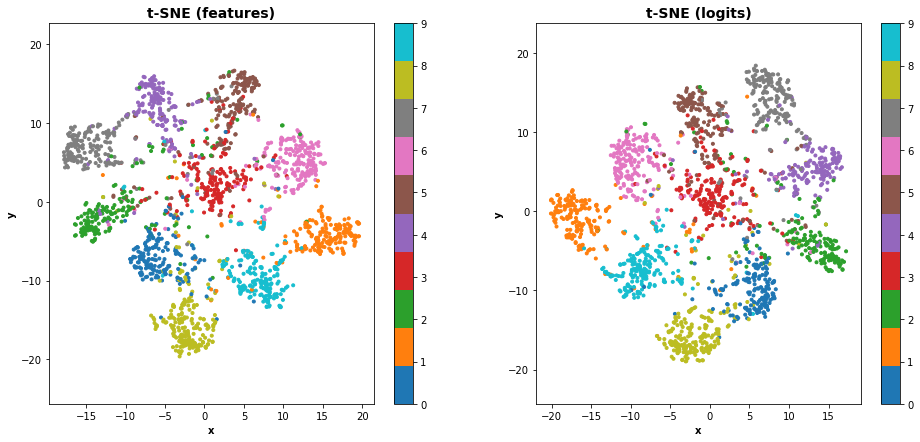

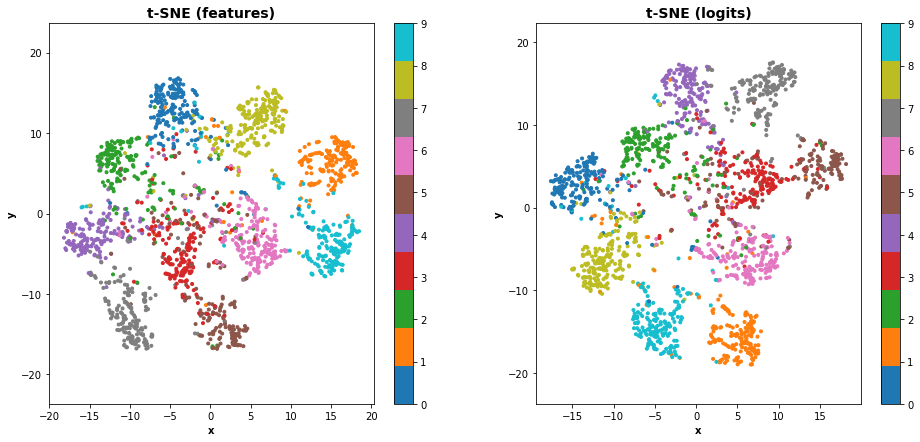

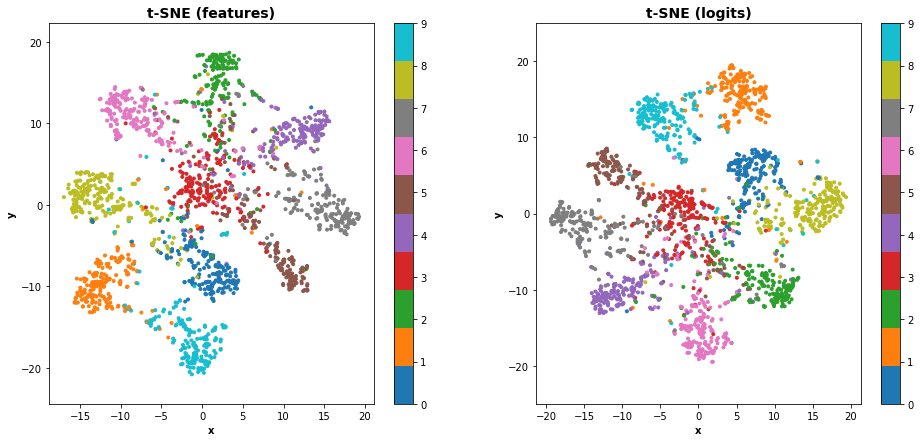

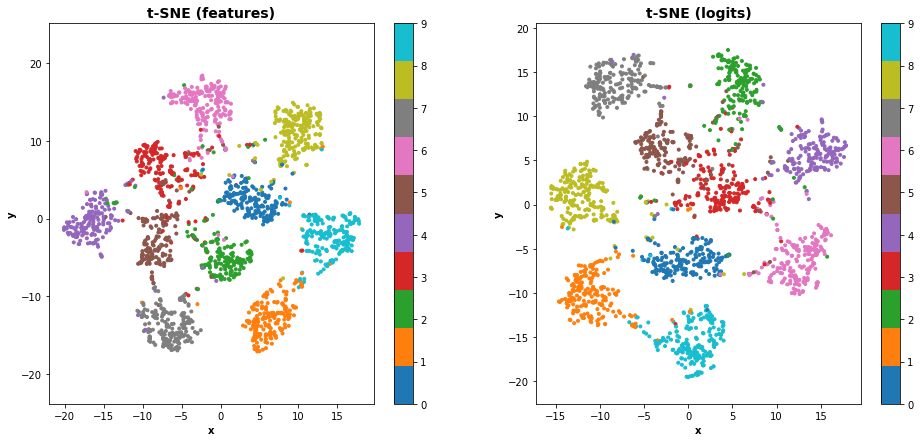

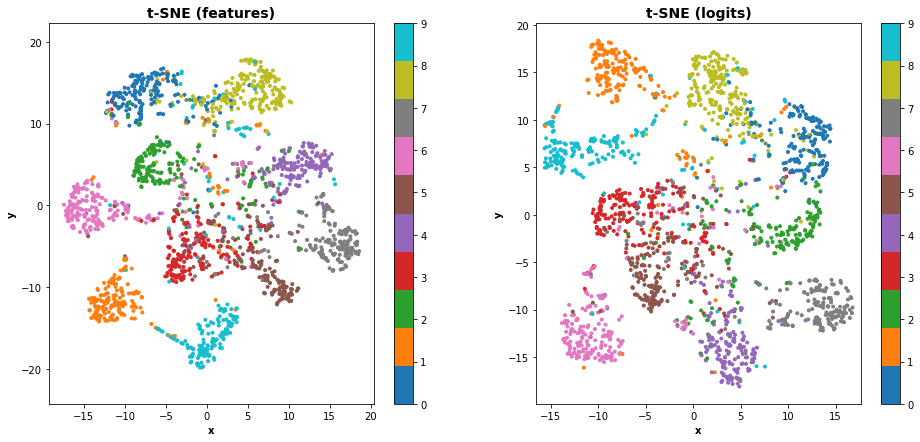

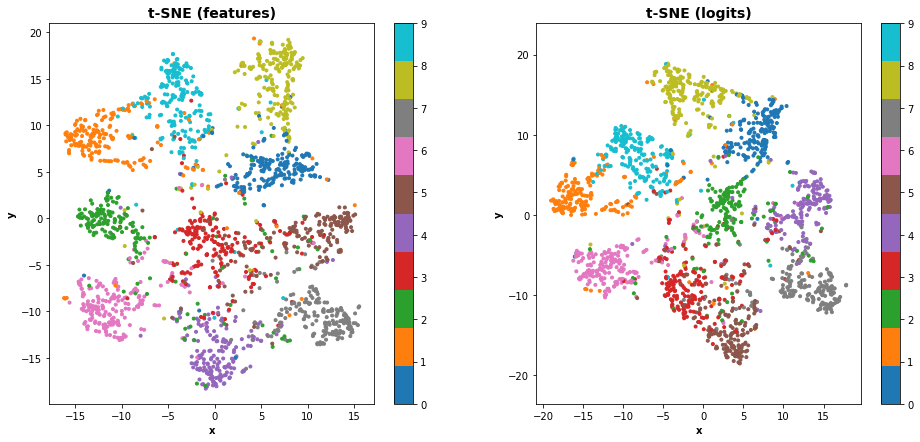

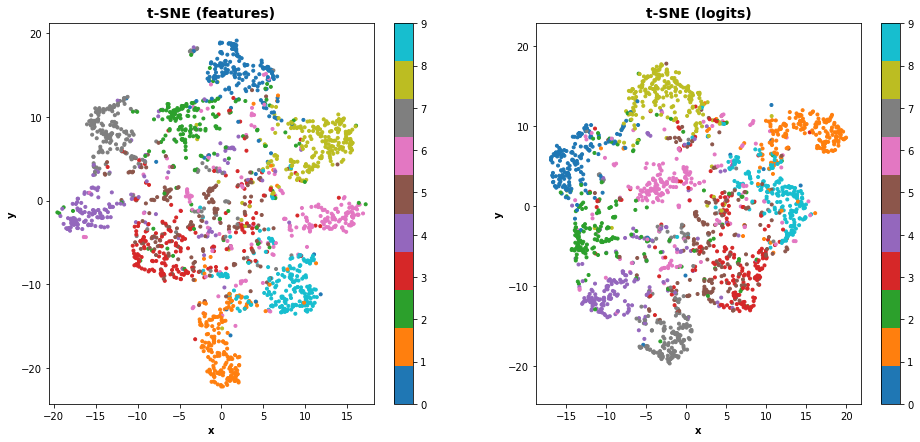

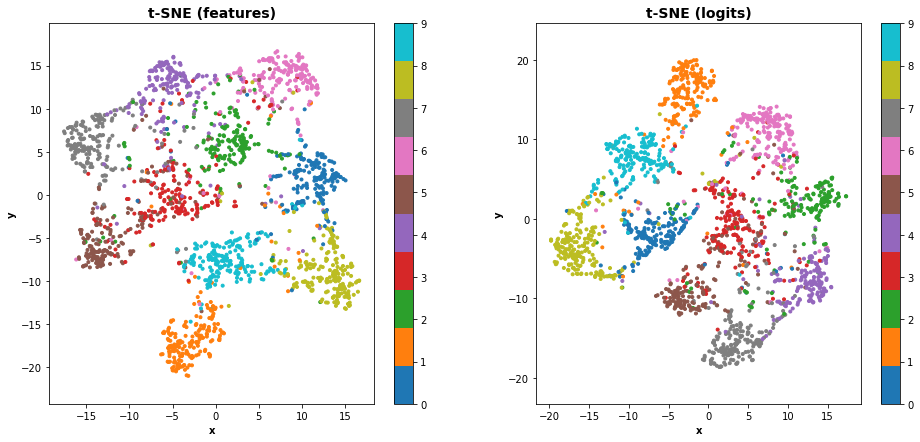

In [263]:
test_c_acc, test_c_table, test_c_cm = test_c(net, test_data, args, base_c_path)